<a href="https://colab.research.google.com/github/gilad-altshuler/Three_Body_RNN/blob/main/notebooks/2_Solution_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import sys, os
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Colab. Cloning repo...")
    !git clone https://github.com/gilad-altshuler/Beyond_Linear_Summation-Three_Body_RNNs.git
    %cd Beyond_Linear_Summation-Three_Body_RNNs
    ROOT = Path(".").resolve()

    # Load Arial font
    !wget -O Arial.ttf "https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf"

else:
    print("Not running in Colab.")
    ROOT = Path(__file__).resolve().parent.parent
    sys.path.append(str(ROOT))

Running in Colab. Cloning repo...
Cloning into 'Beyond_Linear_Summation-Three_Body_RNNs'...
remote: Enumerating objects: 1227, done.
remote: Counting objects: 100% (291/291), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 1227 (delta 161), reused 177 (delta 76), pack-reused 936 (from 2)
Receiving objects: 100% (1227/1227), 476.34 MiB | 27.54 MiB/s, done.
Resolving deltas: 100% (654/654), done.
Updating files: 100% (95/95), done.
/content/Beyond_Linear_Summation-Three_Body_RNNs
--2025-08-28 07:23:24--  https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matomo-org/travis-scripts/master/fonts/Arial.ttf [following]
--2025-08-28 07:23:24--  https://raw.githubusercontent.com/matomo-org/travis-scripts/master/fonts/Arial.ttf
Resolving raw.

In [2]:
import torch
import random
from torch import nn
import numpy as np

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
%matplotlib inline
if IN_COLAB:
  fm.fontManager.addfont('Arial.ttf')
  arial_fp = fm.FontProperties(fname='Arial.ttf')
  plt.rcParams['font.family'] = arial_fp.get_name()
else:
  plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 10
import seaborn as sns

import methods.utils as utils
from tasks import K_Bit_Flipflop_task, MultiFate_task, sin_task
from methods.models import *

In [3]:
DATA_DIR = ROOT / "data" / "solution_space"
FIG_DIR = ROOT / "notebooks" / "figures"

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
SEED = 3150
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fig. 4 panels preperation

## Phase space diagrams (Panel (a))

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# k - flip-flop
K = 1
T = 1000

# decide on hyperparameters
input_size=K
output_size=K
hidden_dim=30

lr_rnn = Low_Rank_RNN(input_size, output_size, hidden_dim, rank=K, mode='cont',
                      form='rate', task="K_Bit_Flipflop_task", noise_std=0.0,
                      tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)
lr_tbrnn = Low_Rank_TBRNN(input_size, output_size, hidden_dim, rank=K, mode='cont',
                          form='rate', task="K_Bit_Flipflop_task", noise_std=0.0,
                          tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)

lr_rnn.load_state_dict(torch.load(DATA_DIR / "R1_RNN.pth",map_location=DEVICE))
lr_tbrnn.load_state_dict(torch.load(DATA_DIR / "R1_TBRNN.pth",map_location=DEVICE))
long_input = torch.load(DATA_DIR / "long_input.pth",map_location=DEVICE)
long_target = torch.load(DATA_DIR / "long_target.pth",map_location=DEVICE)

In [7]:
idx = 1
fps = [500,630] # known fixed points for this input

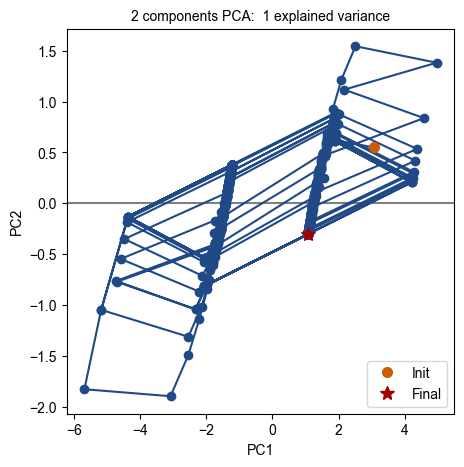

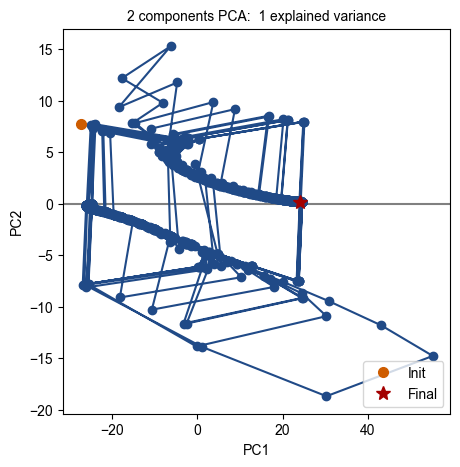

In [8]:
pca_rnn = utils.show_pca_2d(lr_rnn,long_input,idx)
pca_tbrnn = utils.show_pca_2d(lr_tbrnn,long_input,idx)

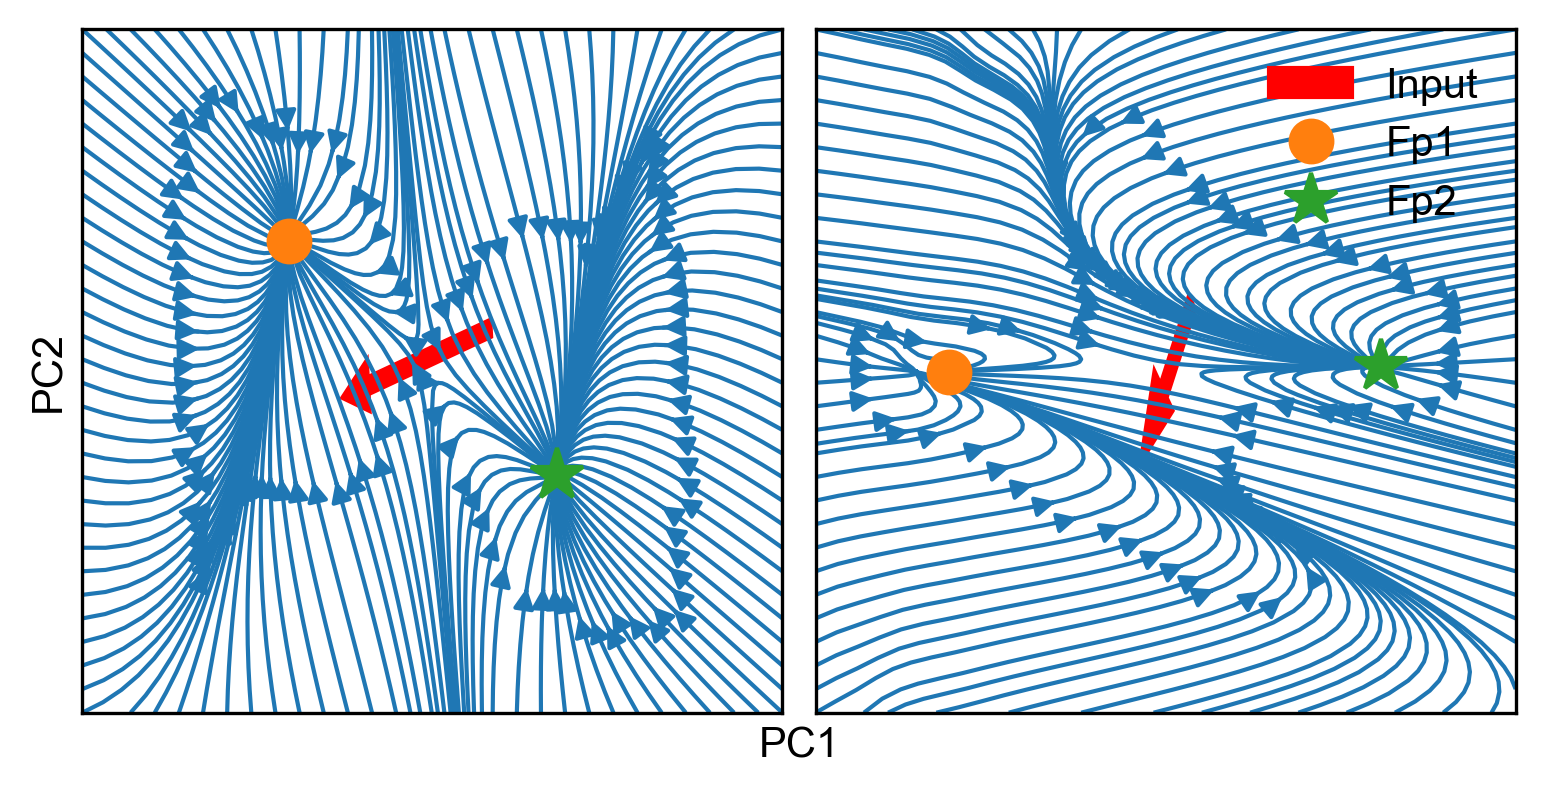

In [9]:
fig = plt.figure(figsize=(5,2.5),dpi=300)
axes = fig.subplots(1, 2)
fig.text(0.5, 0.0, 'PC1', ha='center', va='center', fontsize=10)
fig.text(0.0, 0.5, 'PC2', ha='center', va='center', rotation='vertical', fontsize=10)
### RNN ###
w1 = 3
w2 = 1
Y, X = np.mgrid[-w2:w2:100j, -w1:w1:100j]
W = np.stack((X,Y), axis=-1).reshape(-1,2)
H = torch.tensor(pca_rnn.inverse_transform(W),dtype=torch.float).to(DEVICE)

H1 = lr_rnn(torch.zeros(W.shape[0],1,K).to(DEVICE),H)[1]
H_dot = (H1-H) / lr_rnn.tau


W_dot = pca_rnn.transform(H_dot.cpu().detach().numpy()*10)

X_dot = W_dot[:,0].reshape(100,100)
Y_dot = W_dot[:,1].reshape(100,100)

axes[0].streamplot(X, Y, X_dot, Y_dot,broken_streamlines=False,linewidth=1)

fp1 = lr_rnn(long_input,None)[2][idx,[fps[0]]]
fp2 = lr_rnn(long_input,None)[2][idx,[fps[1]]]

fp1 = pca_rnn.transform(fp1.cpu().detach().numpy())
fp2 = pca_rnn.transform(fp2.cpu().detach().numpy())

input_arrow = pca_rnn.transform(lr_rnn.w_in.weight.T.cpu().detach().numpy())[0]
axes[0].arrow(0.5,0.125,input_arrow[0]/15,input_arrow[1]/15,width=0.05,color='red',label='Input')

axes[0].plot(fp1[0,0],fp1[0,1],'o', ms=10, alpha=1, label="Fp1")
axes[0].plot(fp2[0,0],fp2[0,1], '*', ms=13, alpha=1, label="Fp2")

axes[0].set_xticks([])
axes[0].set_yticks([])

### TBRNN ###
w1 = 40
w2 = 15
Y, X = np.mgrid[-w2:w2:100j, -w1:w1:100j]
W = np.stack((X,Y), axis=-1).reshape(-1,2)
H = torch.tensor(pca_tbrnn.inverse_transform(W),dtype=torch.float).to(DEVICE)

H1 = lr_tbrnn(torch.zeros(W.shape[0],1,K).to(DEVICE),H)[1]
H_dot = (H1-H) / lr_tbrnn.tau


W_dot = pca_tbrnn.transform(H_dot.cpu().detach().numpy()*50)

X_dot = W_dot[:,0].reshape(100,100)
Y_dot = W_dot[:,1].reshape(100,100)

axes[1].streamplot(X, Y, X_dot, Y_dot,broken_streamlines=False,linewidth=1)

fp1 = lr_tbrnn(long_input,None)[2][idx,[fps[0]]]
fp2 = lr_tbrnn(long_input,None)[2][idx,[fps[1]]]

fp1 = pca_tbrnn.transform(fp1.cpu().detach().numpy())
fp2 = pca_tbrnn.transform(fp2.cpu().detach().numpy())

input_arrow = pca_tbrnn.transform(lr_tbrnn.w_in.weight.T.cpu().detach().numpy())[0]
axes[1].arrow(3,3,input_arrow[0]/10,input_arrow[1]/10,width=0.9,color='red',label='Input')

axes[1].plot(fp1[0,0],fp1[0,1],'o', ms=10, alpha=1, label="Fp1")
axes[1].plot(fp2[0,0],fp2[0,1], '*', ms=13, alpha=1, label="Fp2")
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.legend(loc=1,frameon=False,fontsize=10)

plt.tight_layout(pad=.8)
plt.savefig(FIG_DIR / "pca_space.png", dpi=300, bbox_inches='tight')
plt.show()

In [10]:
from PIL import Image

# Open the image
img = Image.open(FIG_DIR / "pca_space.png")

# Dimensions
left_crop = 24
right_crop = 24
top_crop = 24
bottom_crop = 24

# Calculate crop box (left, top, right, bottom)
width, height = img.size
crop_box = (
    left_crop,
    top_crop,
    width - right_crop,
    height - bottom_crop
)

# Crop and save
cropped_img = img.crop(crop_box)
cropped_img.save(FIG_DIR / "pca_space.png", dpi=(300, 300))


demonstrates the correlation differences between RNN and TBRNN fixed points

In [11]:
x1_rnn=lr_rnn(long_input,None)[2][idx,fps[0]].cpu().detach().numpy()
x2_rnn=lr_rnn(long_input,None)[2][idx,fps[1]].cpu().detach().numpy()
corr_rnn = utils.corrvecs(x1_rnn,x2_rnn).item()

x1_tbrnn=lr_tbrnn(long_input,None)[2][idx,fps[0]].cpu().detach().numpy()
x2_tbrnn=lr_tbrnn(long_input,None)[2][idx,fps[1]].cpu().detach().numpy()
corr_tbrnn = utils.corrvecs(x1_tbrnn,x2_tbrnn).item()

print(f"correlation between 2 RNN fixed points: {corr_rnn}")
print(f"correlation between 2 TBRNN fixed points: {corr_tbrnn}")

correlation between 2 RNN fixed points: -1.0000001192092896
correlation between 2 TBRNN fixed points: 1.0


## Comparing RNN and TBRNN to GRU

In [12]:
# k - flip-flop
K = 1
T = 100

# decide on hyperparameters
input_size=K
output_size=K
hidden_dim=30

lr_rnn = Low_Rank_RNN(input_size, output_size, hidden_dim, rank=K, mode='cont',
                      form='rate', task="K_Bit_Flipflop_task", noise_std=0.0,
                      tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)
lr_tbrnn = Low_Rank_TBRNN(input_size, output_size, hidden_dim, rank=K, mode='cont',
                      form='rate', task="K_Bit_Flipflop_task", noise_std=0.0,
                      tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)
lr_gru = Low_Rank_GRU(input_size, output_size, hidden_dim, rank=K, mode='cont',
                      form='rate', task="K_Bit_Flipflop_task", noise_std=0.0,
                      tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)

In [13]:
i = 2
input = torch.load(DATA_DIR / "input.pth", map_location=DEVICE)

lr_rnn.load_state_dict(torch.load(DATA_DIR / "rank_1_RNN.pth",map_location=DEVICE))
lr_tbrnn.load_state_dict(torch.load(DATA_DIR / "rank_1_TBRNN.pth",map_location=DEVICE))
lr_gru.load_state_dict(torch.load(DATA_DIR / "rank_1_GRU.pth",map_location=DEVICE))

<All keys matched successfully>

In [15]:
from methods.utils import CKA
R_rnn_svd = lr_rnn(input, None)[2].reshape(-1,hidden_dim).cpu().detach().numpy()
R_tbrnn_svd = lr_tbrnn(input, None)[2].reshape(-1,hidden_dim).cpu().detach().numpy()
R_gru_svd = lr_gru(input, None)[2].reshape(-1,hidden_dim).cpu().detach().numpy()
matrices = [R_rnn_svd,R_tbrnn_svd,R_gru_svd]
corrmatrix = [[CKA(i, j) for j in matrices] for i in matrices]

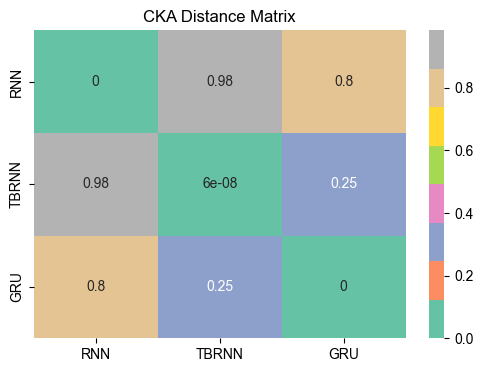

In [16]:
labels = ['RNN', 'TBRNN', 'GRU']

import seaborn as sns

# correlation_matrix = np.corrcoef(V_rnn.T,V_tbrnn.T)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(1-np.array(corrmatrix), annot=True, cmap='Set2',xticklabels=labels, yticklabels=labels)
plt.title('CKA Distance Matrix')
plt.show()

## Get full distance CKA matrix (Panel (b))

Plot MDS on D matrix

In [17]:
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from matplotlib.collections import LineCollection
from matplotlib.colors import to_rgb
from scipy.stats import gaussian_kde
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D
from sklearn.manifold import MDS

# Function to draw 1σ Gaussian ellipse
def plot_cov_ellipse(mean, cov, ax, n_std=1.5, facecolor='none', edgecolor='k', alpha=0.3, min_var=1e-3, **kwargs):
    # Eigen-decomposition of covariance
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # Clamp eigenvalues to avoid vanishing ellipses
    vals = np.clip(vals, min_var, None)

    # Width and height scaled by desired sigma
    width, height = 2 * n_std * np.sqrt(vals)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    ellipse = patches.Ellipse(mean, width, height, angle=angle,
                              facecolor=facecolor, edgecolor=edgecolor,
                              alpha=alpha, **kwargs)
    ax.add_patch(ellipse)

def draw_segmented_gradient_edge(ax, p1, p2, c1, c2, steps=300, linewidth=2, dash_on=5, dash_off=5):
    """
    Draw dashed gradient line between p1 and p2 with color from c1 to c2.
    Uses visible/invisible segment skipping for true dashed effect.
    """
    x = np.linspace(p1[0], p2[0], steps)
    y = np.linspace(p1[1], p2[1], steps)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Gradient colors
    c1 = np.array(to_rgb(c1))
    c2 = np.array(to_rgb(c2))
    t = np.linspace(0, 1, len(segments)).reshape(-1, 1)
    colors = c1 + (c2 - c1) * t

    # Build dash mask (on/off pattern)
    pattern = [1]*dash_on + [0]*dash_off
    mask = np.tile(pattern, int(np.ceil(len(segments) / len(pattern))))[:len(segments)]

    # Keep only the visible segments
    visible_segments = segments[mask == 1]
    visible_colors = colors[mask == 1]

    lc = LineCollection(visible_segments, colors=visible_colors, linewidth=linewidth, capstyle='butt')
    ax.add_collection(lc)

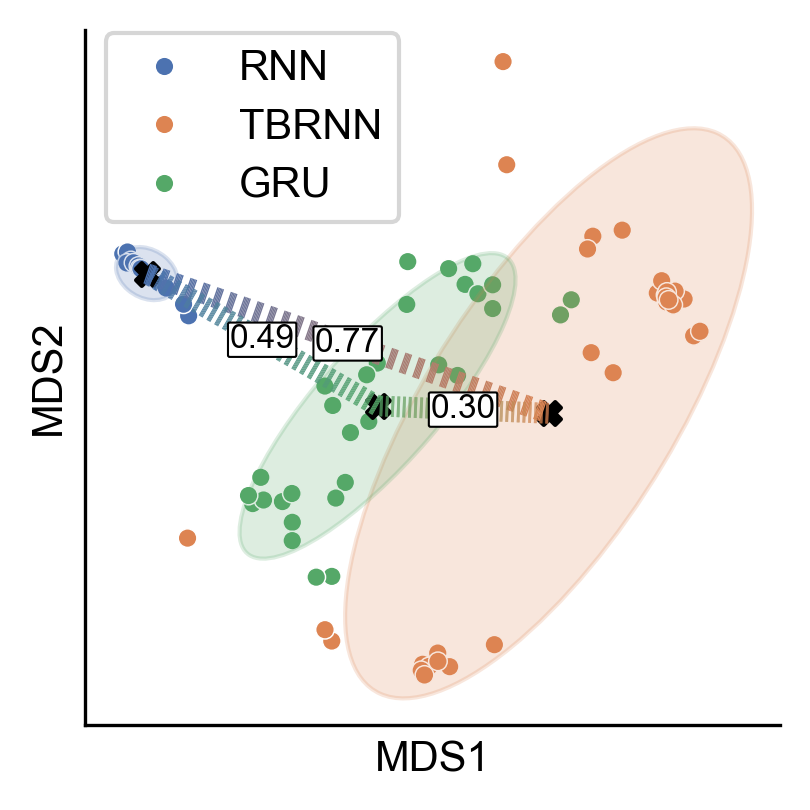

In [18]:
MODELS = ['RNN','TBRNN','TBRNN_same','GRU']
D = np.load(DATA_DIR / "distance_matrix.npy")
RUNS = D.shape[0] // len(MODELS)

#  MDS projection
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
D_without = np.concatenate((D[:2*RUNS],D[3*RUNS:]),axis=0)
D_without = np.concatenate((D_without[:,:2*RUNS],D_without[:,3*RUNS:]),axis=1)
coords = mds.fit_transform(D_without)  # we will take without tbrnns_same, since they have the same stats
# coords = mds.fit_transform(D) # alternatively can uncomment to plot whole D.

# Assign model types
labels = [MODELS[0]] * RUNS + [MODELS[1]] * RUNS + [MODELS[3]] * RUNS


# Convert to DataFrame
df = pd.DataFrame({
    'x': coords[:, 0],
    'y': coords[:, 1],
    'Model Type': labels
})

# Centers of mass
com_df = df.groupby("Model Type")[["x", "y"]].mean()
com_coords = com_df.values
model_types = com_df.index.tolist()

# Distance matrix between C.O.M.s
dist_matrix = squareform(pdist(com_coords))
triangle_edges = [(0, 1), (1, 2), (2, 0)]
triangle_colors = ['tab:blue', 'tab:green', 'tab:red']

# Plot setup
plt.figure(figsize=(2.5, 2.5), dpi=300)
sns.scatterplot(data=df, x='x', y='y', hue='Model Type', palette='deep', s=20)

# Get consistent colors from seaborn palette
palette = sns.color_palette('deep')
model_types = df['Model Type'].unique()
group_colors = dict(zip(model_types, palette))  # {'RNN': ..., 'TBRNN': ..., 'GRU': ...}

# Add ellipses after scatterplot
ax = plt.gca()
for group in model_types:
    group_data = df[df['Model Type'] == group][['x', 'y']].values
    if group_data.shape[0] >= 2:
        mean = group_data.mean(axis=0)
        cov = np.cov(group_data, rowvar=False)
        color = group_colors[group]
        plot_cov_ellipse(mean, cov, ax,
                         facecolor=color,
                         edgecolor=color,
                         alpha=0.2)


# Get RGB colors for blending
rgb_colors = {k: to_rgb(v) for k, v in group_colors.items()}

# Create explicit name-to-center mapping
com_df = df.groupby("Model Type")[["x", "y"]].mean()
com_coords_dict = {
    name: np.array([vals["x"], vals["y"]])
    for name, vals in com_df.to_dict("index").items()
}

# Triangle edges by model name
triangle_edges_named = [
    ('RNN', 'TBRNN'),
    ('TBRNN', 'GRU'),
    ('GRU', 'RNN')
]

for name1, name2 in triangle_edges_named:
    p1 = com_coords_dict[name1]
    p2 = com_coords_dict[name2]
    c1 = group_colors[name1]
    c2 = group_colors[name2]

    draw_segmented_gradient_edge(ax, p1, p2, c1, c2, steps=300, linewidth=5, dash_on=5, dash_off=5)

    # Annotate distance
    mid_x = (p1[0] + p2[0]) / 2
    mid_y = (p1[1] + p2[1]) / 2
    dist = np.linalg.norm(np.array(p1) - np.array(p2))
    ax.text(mid_x, mid_y, f"{dist:.2f}", fontsize=8,
            ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.05", fc="white", ec="black", lw=0.5))

# Mark C.O.M.
for i, name in enumerate(model_types):
    x, y = com_coords[i]
    plt.scatter(x, y, c='black', s=30, marker='X')

sns.despine()

plt.xlabel("MDS1",fontsize=10)
plt.ylabel("MDS2",fontsize=10)
plt.legend(frameon=True, fontsize=10,loc='upper left',bbox_to_anchor=(0.0, 1.025))
plt.xticks([])
plt.yticks([])
plt.tight_layout(pad=0)
plt.savefig(FIG_DIR / "mds.png", dpi=300)
plt.show()

## Combine plots

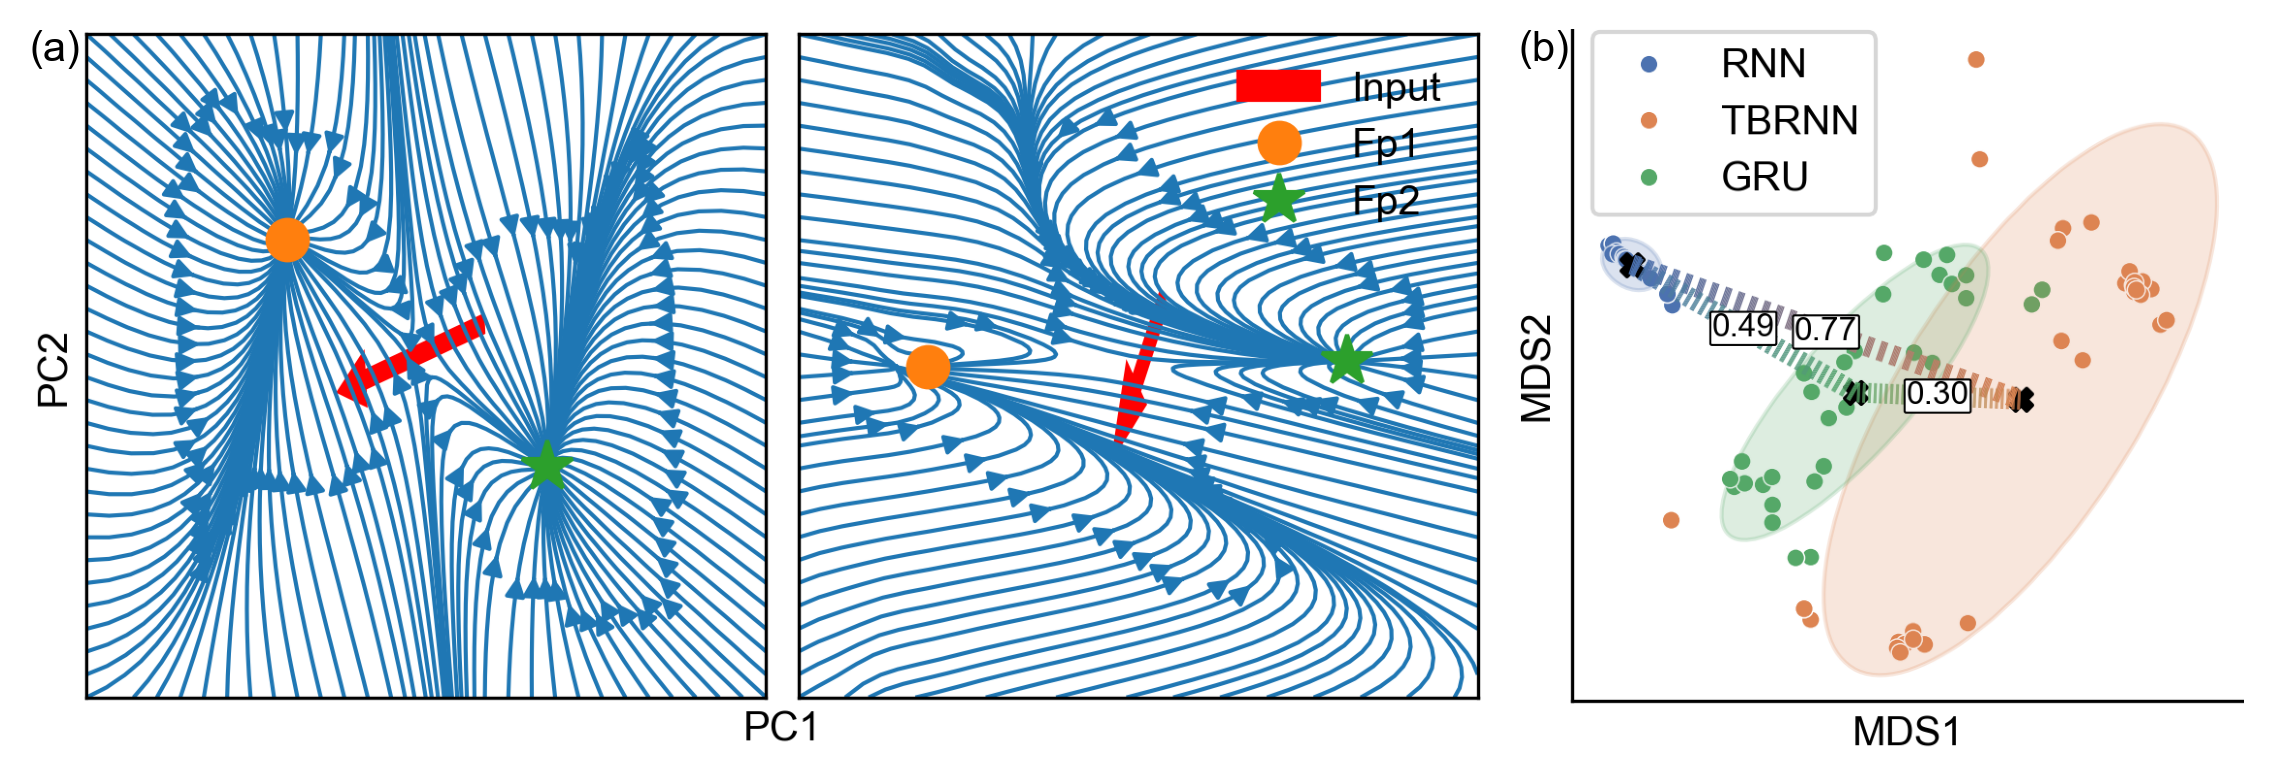

In [19]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

fig, axes = plt.subplot_mosaic(
    [["pca_space", "mds"]],
    gridspec_kw={"width_ratios": [2, 1]},
    figsize=(7.5, 2.5),
    dpi=300,
    constrained_layout=True
)

plots = ["pca_space", "mds"]

for plot in plots:
  img = Image.open(FIG_DIR / f"{plot}.png")
  axes[plot].imshow(img)
  axes[plot].axis("off")

# Add subplot labels
labels = ['(a)', '(b)']
for ax, label in zip(list(axes.values()), labels):
  ax.text(
      0.0, 1.0, label, transform=ax.transAxes,
      fontsize=10, fontweight='bold', va='top', ha='left'
  )

plt.savefig(FIG_DIR / "Solution Space.png", dpi=300, transparent=True)
plt.savefig(FIG_DIR / "Solution Space.tiff", dpi=300, format='tiff', transparent=True)
plt.show()

In [20]:
from PIL import Image

# Load image
img = Image.open(FIG_DIR / "Solution Space.png")

# Get pixel dimensions
width_px, height_px = img.size
print(f"Pixel dimensions: {width_px} × {height_px} pixels")

# Get DPI info (if embedded)
dpi = img.info.get('dpi', (300, 300))  # Default fallback to 300
print(f"DPI: {dpi[0]} x {dpi[1]}")

# Convert to inches
width_in = width_px / dpi[0]
height_in = height_px / dpi[1]
print(f"Size in inches: {float(width_in):.2f} × {float(height_in):.2f} inches")

Pixel dimensions: 2250 × 750 pixels
DPI: 299.9994 x 299.9994
Size in inches: 7.50 × 2.50 inches
